In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn.init as init


In [2]:
#hyperparameters
n_epochs = 150
batch_size_train = 294
batch_size_test = 315
learning_rate = 0.2
momentum = 0.1
log_interval =10
random_seed = 1
n_output = 1



torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [3]:
data = pd.read_excel('arranged_data-2inps.xlsx')

data.shape

(8, 3)

In [4]:
def Split(data,train, test_size = 0.3):
    train_data,test_data = train_test_split(data, train_size = 1-test_size, random_state = 7)
    if train:
        normalized_input,normalized_output = Normalize0_1(train_data)
    else:
        normalized_input,normalized_output = Normalize0_1(test_data)
    return normalized_input,normalized_output

def Normalize0_1(data):
    global n
    n = data.shape[1]
    _min = data.min().values
    _max = data.max().values
    input_max = _max[0:(n - n_output)]
    input_min = _min[0:(n - n_output)]
    out_max =_max[(n - n_output)]
    out_min = _min[(n - n_output)]
    
    nor_input = (data.iloc[:, : (n - n_output)]-input_min)/(input_max-input_min)
    nor_output = (data.iloc[:, (n - n_output):]-out_min)/(out_max-out_min)
    
    return nor_input,nor_output


#b.to_excel('dimagkharab2.xlsx')

In [5]:
#a, b = Split(train=True)

#torch.tensor(a.values, dtype=torch.float32)

In [6]:
class RainfallDischarge(Dataset):
    def __init__(self, train,test_size,file = 'arranged_data.xlsx'):
        super().__init__()
        self.data = pd.read_excel(file)
        self.train = train
        self.test_size = test_size
        #self.train_data, self.test_data = train_test_split(self.data, test_size = test_size, random_state = 7)
        self.inputs, self.targets = Split(self.data, self.train, test_size = self.test_size)
        
        self.inputs = torch.tensor(self.inputs.values, dtype=torch.float32)
        self.targets = torch.tensor(self.targets.values, dtype=torch.float32)

        if len(self.inputs) != len(self.targets):
            raise ValueError("The number of inputs and targets are different.")
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_variables = self.inputs[idx]
        output_variables = self.targets[idx]
        return input_variables,output_variables
    
    


In [7]:
train_dataloader = DataLoader(dataset= RainfallDischarge(train = True,test_size= 0.3), batch_size= batch_size_train,shuffle= True)
test_dataloader = DataLoader(dataset= RainfallDischarge(train=False,test_size=0.3),batch_size= batch_size_test,shuffle=True)

In [8]:
example_data = enumerate(train_dataloader)
print(len(train_dataloader))

batch_idx,(batch_input, batch_target) = next(example_data)



5


In [9]:
test_losses = []
test_counter    = [i * len(train_dataloader.dataset) for i in range(n_epochs + 1)]
training_losses = []
training_counter = []

In [10]:
class RRNet(nn.Module):
    def __init__(self):
        super(RRNet, self).__init__()
        input_dimension = n-n_output

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dimension,out_features=100,bias=True),
            nn.ReLU(),
            nn.Linear(in_features= 100 ,out_features=50,bias=True),
            nn.ReLU(),
            #nn.Dropout2d(0.1),
            nn.Linear(in_features=50,out_features=25,bias= True),
            nn.ReLU(),
            nn.Linear(in_features=25,out_features=5,bias= True),
            #nn.Dropout2d(0.1),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1,bias=True),
            nn.ReLU()
            #nn.Sigmoid()
        )
        
            # Initializing weights to 0.1 and biases to 0
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0.0)
        
    def forward(self,x):
        x = self.net(x)
        return x
            
        

In [11]:
network = RRNet()
optimizer = optim.SGD(network.parameters(), lr = learning_rate,momentum=momentum)


In [12]:

def train(epoch):
    network.train()
    for batch_idx,(input,target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = network(input)
        target = target

        if (epoch == n_epochs +2):
            pd.DataFrame(target.numpy()).to_excel('nntarget.xlsx')
            pd.DataFrame(output.detach().numpy()).to_excel('nnoutput.xlsx')
        loss = F.mse_loss(output,target)
        loss.backward()
        optimizer.step()

        print('Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(
            epoch, batch_idx*len(input),len(train_dataloader.dataset),
            100.* batch_idx*len(input)/len(train_dataloader.dataset),loss.item()
            ))

        training_losses.append(loss.item())
        training_counter.append(batch_idx*batch_size_train + (epoch-1)*len(train_dataloader.dataset))
    # Save the model and optimizer state dictionaries to files
    torch.save(network.state_dict(), 'rr-model.pth')
    torch.save(optimizer.state_dict(), 'rr-optimizer.pth')

In [13]:
def test():
    network.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx,(input, target) in enumerate(test_dataloader):
            output = network(input)
            pd.DataFrame(target.numpy()).to_excel('nntarget2in.xlsx')
            pd.DataFrame(output.numpy()).to_excel('nnoutput2inp.xlsx')
            test_loss += F.mse_loss(output, target).item()
            
        
        test_losses.append(test_loss)

        print('Test set:{} |Average MSE:{}'.format(batch_idx,test_loss))

In [14]:

test()
for epoch in range(1, n_epochs + 1):
    
        # Print weights and biases
    print("After epoch %d:" % (epoch + 1))
    #for name, param in network.named_parameters():
        #if 'weight' in name:
            #print(name, param.data)
        #elif 'bias' in name:
            #print(name, param.data)
    train(epoch)
    t = test()
    


Test set:1 |Average MSE:0.02544103842228651
After epoch 2:
Train Epoch:1 [0/1470 (0%)]	Loss:0.011374
Train Epoch:1 [294/1470 (20%)]	Loss:0.008542
Train Epoch:1 [588/1470 (40%)]	Loss:0.004472
Train Epoch:1 [882/1470 (60%)]	Loss:0.009465
Train Epoch:1 [1176/1470 (80%)]	Loss:0.004539
Test set:1 |Average MSE:0.015531831420958042
After epoch 3:
Train Epoch:2 [0/1470 (0%)]	Loss:0.005455
Train Epoch:2 [294/1470 (20%)]	Loss:0.006703
Train Epoch:2 [588/1470 (40%)]	Loss:0.003390
Train Epoch:2 [882/1470 (60%)]	Loss:0.006585
Train Epoch:2 [1176/1470 (80%)]	Loss:0.008019
Test set:1 |Average MSE:0.014093718957155943
After epoch 4:
Train Epoch:3 [0/1470 (0%)]	Loss:0.003695
Train Epoch:3 [294/1470 (20%)]	Loss:0.009979
Train Epoch:3 [588/1470 (40%)]	Loss:0.007638
Train Epoch:3 [882/1470 (60%)]	Loss:0.003331
Train Epoch:3 [1176/1470 (80%)]	Loss:0.002694
Test set:1 |Average MSE:0.012850651517510414
After epoch 5:
Train Epoch:4 [0/1470 (0%)]	Loss:0.006490
Train Epoch:4 [294/1470 (20%)]	Loss:0.003996
Train

Test set:1 |Average MSE:0.001749064598698169
After epoch 31:
Train Epoch:30 [0/1470 (0%)]	Loss:0.000364
Train Epoch:30 [294/1470 (20%)]	Loss:0.000153
Train Epoch:30 [588/1470 (40%)]	Loss:0.000573
Train Epoch:30 [882/1470 (60%)]	Loss:0.000627
Train Epoch:30 [1176/1470 (80%)]	Loss:0.000309
Test set:1 |Average MSE:0.0016765508335083723
After epoch 32:
Train Epoch:31 [0/1470 (0%)]	Loss:0.000189
Train Epoch:31 [294/1470 (20%)]	Loss:0.000490
Train Epoch:31 [588/1470 (40%)]	Loss:0.000249
Train Epoch:31 [882/1470 (60%)]	Loss:0.000627
Train Epoch:31 [1176/1470 (80%)]	Loss:0.000360
Test set:1 |Average MSE:0.001608758291695267
After epoch 33:
Train Epoch:32 [0/1470 (0%)]	Loss:0.000456
Train Epoch:32 [294/1470 (20%)]	Loss:0.000242
Train Epoch:32 [588/1470 (40%)]	Loss:0.000277
Train Epoch:32 [882/1470 (60%)]	Loss:0.000510
Train Epoch:32 [1176/1470 (80%)]	Loss:0.000340
Test set:1 |Average MSE:0.0015530427335761487
After epoch 34:
Train Epoch:33 [0/1470 (0%)]	Loss:0.000449
Train Epoch:33 [294/1470 (2

Train Epoch:58 [882/1470 (60%)]	Loss:0.000150
Train Epoch:58 [1176/1470 (80%)]	Loss:0.000109
Test set:1 |Average MSE:0.0009265493135899305
After epoch 60:
Train Epoch:59 [0/1470 (0%)]	Loss:0.000135
Train Epoch:59 [294/1470 (20%)]	Loss:0.000201
Train Epoch:59 [588/1470 (40%)]	Loss:0.000171
Train Epoch:59 [882/1470 (60%)]	Loss:0.000112
Train Epoch:59 [1176/1470 (80%)]	Loss:0.000222
Test set:1 |Average MSE:0.0009136313456110656
After epoch 61:
Train Epoch:60 [0/1470 (0%)]	Loss:0.000241
Train Epoch:60 [294/1470 (20%)]	Loss:0.000228
Train Epoch:60 [588/1470 (40%)]	Loss:0.000117
Train Epoch:60 [882/1470 (60%)]	Loss:0.000198
Train Epoch:60 [1176/1470 (80%)]	Loss:0.000059
Test set:1 |Average MSE:0.0009083775221370161
After epoch 62:
Train Epoch:61 [0/1470 (0%)]	Loss:0.000105
Train Epoch:61 [294/1470 (20%)]	Loss:0.000117
Train Epoch:61 [588/1470 (40%)]	Loss:0.000150
Train Epoch:61 [882/1470 (60%)]	Loss:0.000161
Train Epoch:61 [1176/1470 (80%)]	Loss:0.000290
Test set:1 |Average MSE:0.00091817244

Test set:1 |Average MSE:0.0008005572308320552
After epoch 88:
Train Epoch:87 [0/1470 (0%)]	Loss:0.000092
Train Epoch:87 [294/1470 (20%)]	Loss:0.000079
Train Epoch:87 [588/1470 (40%)]	Loss:0.000220
Train Epoch:87 [882/1470 (60%)]	Loss:0.000119
Train Epoch:87 [1176/1470 (80%)]	Loss:0.000208
Test set:1 |Average MSE:0.000797509215772152
After epoch 89:
Train Epoch:88 [0/1470 (0%)]	Loss:0.000232
Train Epoch:88 [294/1470 (20%)]	Loss:0.000148
Train Epoch:88 [588/1470 (40%)]	Loss:0.000085
Train Epoch:88 [882/1470 (60%)]	Loss:0.000151
Train Epoch:88 [1176/1470 (80%)]	Loss:0.000108
Test set:1 |Average MSE:0.0007877247116994113
After epoch 90:
Train Epoch:89 [0/1470 (0%)]	Loss:0.000061
Train Epoch:89 [294/1470 (20%)]	Loss:0.000215
Train Epoch:89 [588/1470 (40%)]	Loss:0.000295
Train Epoch:89 [882/1470 (60%)]	Loss:0.000103
Train Epoch:89 [1176/1470 (80%)]	Loss:0.000053
Test set:1 |Average MSE:0.0007938104390632361
After epoch 91:
Train Epoch:90 [0/1470 (0%)]	Loss:0.000187
Train Epoch:90 [294/1470 (

Test set:1 |Average MSE:0.0007491035794373602
After epoch 116:
Train Epoch:115 [0/1470 (0%)]	Loss:0.000237
Train Epoch:115 [294/1470 (20%)]	Loss:0.000083
Train Epoch:115 [588/1470 (40%)]	Loss:0.000115
Train Epoch:115 [882/1470 (60%)]	Loss:0.000090
Train Epoch:115 [1176/1470 (80%)]	Loss:0.000141
Test set:1 |Average MSE:0.0007375044224318117
After epoch 117:
Train Epoch:116 [0/1470 (0%)]	Loss:0.000133
Train Epoch:116 [294/1470 (20%)]	Loss:0.000136
Train Epoch:116 [588/1470 (40%)]	Loss:0.000094
Train Epoch:116 [882/1470 (60%)]	Loss:0.000166
Train Epoch:116 [1176/1470 (80%)]	Loss:0.000139
Test set:1 |Average MSE:0.0007395224238280207
After epoch 118:
Train Epoch:117 [0/1470 (0%)]	Loss:0.000136
Train Epoch:117 [294/1470 (20%)]	Loss:0.000094
Train Epoch:117 [588/1470 (40%)]	Loss:0.000190
Train Epoch:117 [882/1470 (60%)]	Loss:0.000101
Train Epoch:117 [1176/1470 (80%)]	Loss:0.000145
Test set:1 |Average MSE:0.0007479589548893273
After epoch 119:
Train Epoch:118 [0/1470 (0%)]	Loss:0.000147
Train

Train Epoch:143 [294/1470 (20%)]	Loss:0.000191
Train Epoch:143 [588/1470 (40%)]	Loss:0.000133
Train Epoch:143 [882/1470 (60%)]	Loss:0.000119
Train Epoch:143 [1176/1470 (80%)]	Loss:0.000114
Test set:1 |Average MSE:0.0007044182566460222
After epoch 145:
Train Epoch:144 [0/1470 (0%)]	Loss:0.000153
Train Epoch:144 [294/1470 (20%)]	Loss:0.000107
Train Epoch:144 [588/1470 (40%)]	Loss:0.000094
Train Epoch:144 [882/1470 (60%)]	Loss:0.000106
Train Epoch:144 [1176/1470 (80%)]	Loss:0.000173
Test set:1 |Average MSE:0.0007093673048075289
After epoch 146:
Train Epoch:145 [0/1470 (0%)]	Loss:0.000083
Train Epoch:145 [294/1470 (20%)]	Loss:0.000175
Train Epoch:145 [588/1470 (40%)]	Loss:0.000108
Train Epoch:145 [882/1470 (60%)]	Loss:0.000158
Train Epoch:145 [1176/1470 (80%)]	Loss:0.000101
Test set:1 |Average MSE:0.0006990405963733792
After epoch 147:
Train Epoch:146 [0/1470 (0%)]	Loss:0.000143
Train Epoch:146 [294/1470 (20%)]	Loss:0.000184
Train Epoch:146 [588/1470 (40%)]	Loss:0.000121
Train Epoch:146 [8

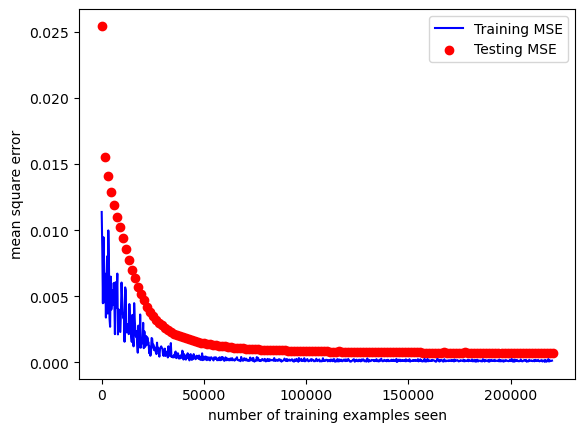

In [15]:

fig = plt.figure()
plt.plot(training_counter,training_losses,color = 'blue')
plt.scatter(test_counter,test_losses,color = 'red')
plt.xlabel('number of training examples seen')
plt.ylabel('mean square error')
plt.legend(['Training MSE','Testing MSE'])

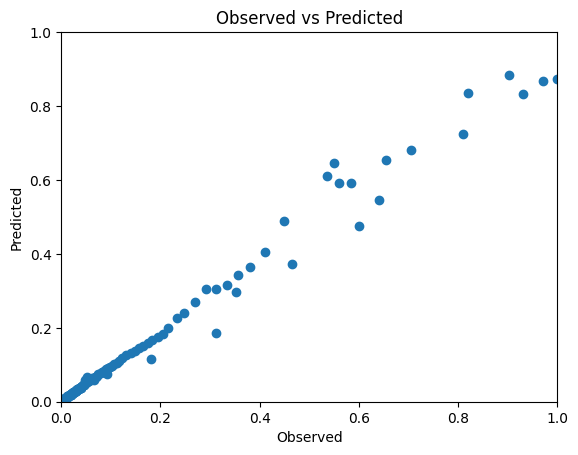

0.0007891942514106631

In [16]:
#testing the data
test_data_new = pd.DataFrame(pd.read_excel('arranged_data-geda.xlsx'))

#inputs_new = test_data_new.iloc[:,:9].values
#targets_new = test_data_new.iloc[:,9:].values

# Convert the test data to PyTorch tensors
inputs_new,targets_new = Normalize0_1(test_data_new)

inputs_new = torch.tensor(inputs_new.values,dtype=torch.float32)
target_new = torch.tensor(targets_new.values,dtype=torch.float32)
#targets_new = torch.tensor(targets_new).float()

#targets_new = (targets_new-min(targets_new))/(max(targets_new)-min(targets_new))

# Make predictions using the trained model
network.eval()
with torch.no_grad():
    outputs_new = network(inputs_new)
    tes_losss = F.mse_loss(outputs_new, target_new).item()

# Convert the predicted values to a numpy array
#outputs_new = outputs_new.numpy()

# Plot the observed vs predicted values
fig, ax = plt.subplots()
ax.scatter(targets_new, outputs_new, alpha=1)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title('Observed vs Predicted')
#ax.set_aspect('equal', 'box')
ax.set_xlim([0, 1]) # Set the x-axis limits to 0 and 1
ax.set_ylim([0, 1]) # Set the y-axis limits to 0 and 1
plt.show()

tes_losss